In [1]:
import folium
import branca
import numpy as np
import pandas as pd
from MoviaBusDataset import MoviaBusDataset
import matplotlib.pyplot as plt

In [2]:
prev_timesteps = 0
prediction_steps = 0

train = MoviaBusDataset('../data/train', 
                        interpolation=True,
                        max_future_time_steps=prediction_steps,
                        timeofday=True,
                        agg_time=5)
test = MoviaBusDataset('../data/test', 
                       interpolation=True,
                       max_future_time_steps=prediction_steps,
                       timeofday=True,
                       agg_time=5)
train = pd.concat(train.dataframes).unstack().reset_index().rename(columns={0:"Speed"})
test = pd.concat(test.dataframes).unstack().reset_index().rename(columns={0:"Speed"})

C:\Users\rigr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [285]:
train2 = train.pivot(index='Time', columns='level_0',values='Speed')
train3 = train2.groupby(['TimeOfDay']).mean()
#train3.head()

In [286]:
test2 = test.pivot(index='Time', columns='LinkRef',values='Speed')
test3 = test2.groupby(['TimeOfDay']).mean()
#test3.head(). This is the mean for all the test days and hence the wrong data 

In [267]:
testday1 = test2[0:193].groupby(['TimeOfDay']).mean()
testday2 = test2[193:386].groupby(['TimeOfDay']).mean()
testday3 = test2[386:579].groupby(['TimeOfDay']).mean()
testday4 = test2[579:772].groupby(['TimeOfDay']).mean()
testday5 = test2[772:965].groupby(['TimeOfDay']).mean()

In [284]:
MAE1 = abs(testday1-train3).mean().mean()
MAE2 = abs(testday2-train3).mean().mean()
MAE3 = abs(testday3-train3).mean().mean()
MAE4 = abs(testday4-train3).mean().mean()
MAE5 = abs(testday5-train3).mean().mean()

print('Mean absolute error DAY1: ',MAE1)
print('Mean absolute error DAY2: ',MAE2)
print('Mean absolute error DAY3: ',MAE3)
print('Mean absolute error DAY4: ',MAE4)
print('Mean absolute error DAY5: ',MAE5)

print('\nMean of all days: ',sum([MAE1,MAE2,MAE3,MAE4,MAE5])/5)

Mean absolute error DAY1:  1.7072348735395055
Mean absolute error DAY2:  1.6663742552740684
Mean absolute error DAY3:  1.7009672956227537
Mean absolute error DAY4:  1.613143839149059
Mean absolute error DAY5:  1.7305747488605177

Mean of all days:  1.6836590024891809


In [32]:
#Dette er for gennemsnitlig hastigheder for alle dage 
MAE = abs(test3-train3).mean().mean()
MAE

0.9492555047126241

In [9]:
RMSE = np.sqrt(((test3-train3)**2).mean().mean())
RMSE

1.2938306858883448

Text(0,0.5,'Mean speed [m/2]')

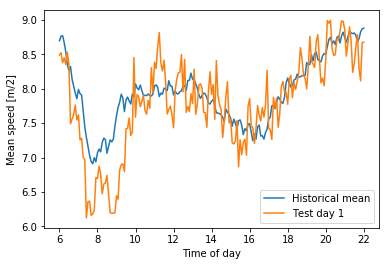

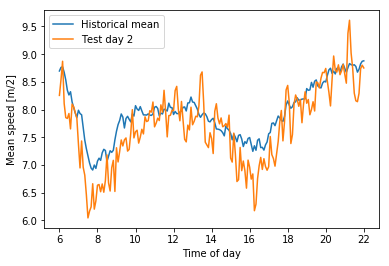

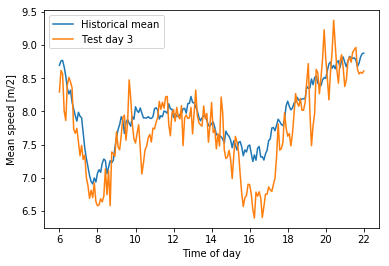

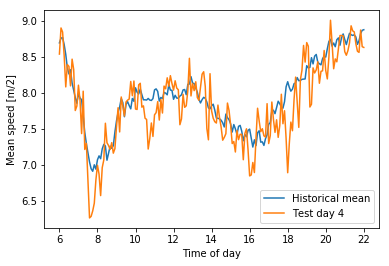

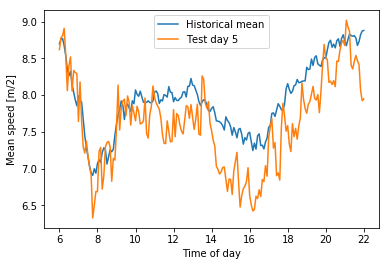

In [300]:
newTime = [6+(22-6)/192*i for i in range(0,193)]
#test3.index = [6+(22-6)/192*i for i in range(0,193)]
train3.index = newTime
testday1.index = newTime
testday2.index = newTime
testday3.index = newTime
testday4.index = newTime
testday5.index = newTime


plt.plot(train3.mean(1))
plt.plot(testday1.mean(1))
plt.legend(['Historical mean','Test day 1'])
plt.xlabel('Time of day')
plt.ylabel('Mean speed [m/2]')

plt.figure()
plt.plot(train3.mean(1))
plt.plot(testday2.mean(1))
plt.legend(['Historical mean','Test day 2'])
plt.xlabel('Time of day')
plt.ylabel('Mean speed [m/2]')

plt.figure()
plt.plot(train3.mean(1))
plt.plot(testday3.mean(1))
plt.legend(['Historical mean','Test day 3'])
plt.xlabel('Time of day')
plt.ylabel('Mean speed [m/2]')

plt.figure()
plt.plot(train3.mean(1))
plt.plot(testday4.mean(1))
plt.legend(['Historical mean','Test day 4'])
plt.xlabel('Time of day')
plt.ylabel('Mean speed [m/2]')

plt.figure()
plt.plot(train3.mean(1))
plt.plot(testday5.mean(1))
plt.legend(['Historical mean','Test day 5'])
plt.xlabel('Time of day')
plt.ylabel('Mean speed [m/2]')

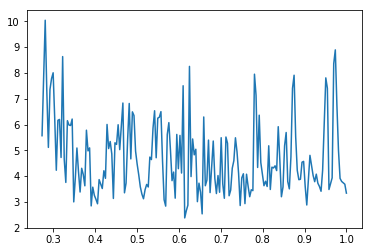

In [93]:
plt.plot(train3['87502481:4279694295:4279694293'])

In [302]:
def Remove(duplicate): 
    final_list = [] 
    for num in duplicate: 
        if num not in final_list: 
            final_list.append(num) 
    return final_list

linkrefs = train.groupby(['level_0']).mean()
linkrefs = [linkref.split(':') for linkref in  linkrefs.index[0:-1].tolist()]
wayID = [linkrefs[i].pop(0) for i in range(len(linkrefs))]
train3.columns = wayID

In [303]:
train2.mean().max()

13.530210376218534

In [304]:
#Create two colormaps, one for the mean speed and one for the number of meassurements
cm_mean = branca.colormap.linear.YlOrRd_04.scale(train2.mean().min(),train2.mean().max())

#Create a map object in valby
m = folium.Map(location=[55.66,12.515], zoom_start=15)

#Define two style functions, that change the color depending on the value of the mean speed/count
def style_trafic_mean(feature):
    wayid = feature['properties']['WayId']
    if str(wayid) in wayID:
        val = train3[str(wayid)].mean()
        if np.size(val) > 1:
            val = val.mean()
        return {
                'fillOpacity': 0.5,
                'weight': 10,
                'color':cm_mean(val)
        }

    else:
        val = 0
        return {
                'fillOpacity': 0,
                'weight': 0,
                'color':0
        }
        
#Add the geojson with colors
g=folium.GeoJson('../data/road_network.geojson',name='mean speed', style_function=style_trafic_mean)
folium.GeoJsonTooltip(['WayId']).add_to(g)
g.add_to(m)
#This is a hack to show a colorbar, and also include all the streets
m.choropleth(geo_data='../data/road_network.geojson'
             , data=train3.mean(), columns=['LinkRef']
             , key_on='feature.properties.WayId'
             , fill_color='YlOrRd'
             , name='Streets'
             , legend_name='Mean speed [m/s]')
#Add a control layer to our map
folium.LayerControl().add_to(m)

#Show the resulting map
m

1